This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter, in a GMM mixture model of the iris data set.

In [1]:
import jax
from jax import numpy as np
from jax import random

import numpy as onp

from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev import result_loading_utils

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# folder to save npz files to produce our paper figures
save_data = True
out_datadir = '/scratch/users/genomic_times_series_bnp/bnp_sensitivity_paper_data/iris/'

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

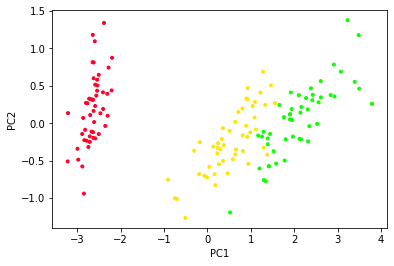

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [5]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
alpha0 = 2.0
prior_params_dict['dp_prior_alpha'] = alpha0
print(prior_params_dict)

{'dp_prior_alpha': 2.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


### Variational parameters

In [6]:
# number of clusters in variational distribution 
k_approx = 15

In [7]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(iris_obs, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(4495.75192152, dtype=float64)

# Optimize KL objective

### Initialize with K-means

In [10]:
# run a kmeans init
t0 = time.time()
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    gmm_optim_lib.cluster_and_get_k_means_inits(iris_obs,
                                            vb_params_paragami, 
                                            n_kmeans_init = n_kmeans_init, 
                                            seed = 54645)
k_means_time = time.time() - t0
print('elapsed (secs): ', k_means_time)

elapsed (secs):  4.906862020492554


In [11]:
print('initial kl: ')
print(gmm_lib.get_kl(iris_obs, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
1268.5666580463758


### Optimize the KL

In [12]:
vb_opt_dict, vb_opt, e_z_opt, out, init_fit_time = \
    gmm_optim_lib.optimize_gmm(iris_obs,
                               init_vb_params_dict,
                               vb_params_paragami,
                               prior_params_dict, 
                               gh_loc, gh_weights, 
                               run_newton = True)

compiling objective and derivatives ... 
done. Compile time: 41.629sec
Running L-BFGS-B ...
L-BFGS-B time: 0.691sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
Newton time: 0.211sec
Newton out:  Optimization terminated successfully.
done. 


In [13]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [14]:
paragami.save_folded('./initial_fit', 
                     vb_opt_dict, 
                     vb_params_paragami, 
                     final_kl = out.fun, 
                     alpha0 = alpha0)

### Check results

In [15]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    
    means = vb_params_dict['centroid_params']['means']
    infos = np.einsum('k, kij -> kij', 
                      vb_params_dict['centroid_params']['wishart_df'], 
                      vb_params_dict['centroid_params']['wishart_scale'])
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, means, np.linalg.inv(infos))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])
    
    return bnp_centroids_pc, bnp_cluster_covs_pc

### Plot centroids

Text(0, 0.5, 'PC2')

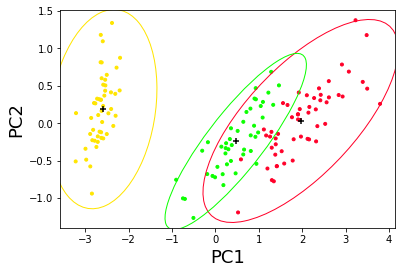

In [16]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

bnp_centroids_pc, bnp_cluster_covs_pc = \
    plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [17]:
# save the data to make the iris plot in PC space
if save_data: 
    print("saving init fit plotting data")
    np.savez(out_datadir + 'iris_fit', 
             pc_iris_obs = pc_iris_obs, 
             pc_centroids = bnp_centroids_pc, 
             pc_cov = bnp_cluster_covs_pc, 
             cluster_memberships = e_z_opt.argmax(1))

saving init fit plotting data


In [18]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [19]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

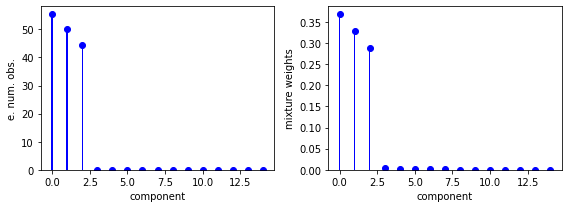

In [20]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()

# Parametric sensitivity

### Compute derivatives

In [21]:
use_free_alpha = False
hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, free = use_free_alpha)

In [22]:
hyper_param0

DeviceArray([2.], dtype=float64)

In [23]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return gmm_lib.get_kl(iris_obs, 
                          vb_params_dict,
                          _prior_params_dict,
                          gh_loc, gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

In [24]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        hyper_param0)

Compiling hessian solver ...
Hessian solver compile time: 77.9026sec

Compiling cross hessian...
Cross-hessian compile time: 1.12603sec

LR sensitivity time: 0.0398173sec



In [25]:
# double check the timing ... 

n_trials = 10
hess_solve_time_samples = onp.zeros(n_trials)
for i in range(n_trials): 
    # this sets the cross-hessian and solves
    # we call "block_util_ready()" inside this method
    # so it should be a fair comparison
    vb_sens._set_dinput_dhyper()
    
    hess_solve_time_samples[i] = vb_sens.lr_time

print(hess_solve_time_samples)
hess_solve_time = hess_solve_time_samples.mean()

LR sensitivity time: 0.0224185sec

LR sensitivity time: 0.0221186sec

LR sensitivity time: 0.0217104sec

LR sensitivity time: 0.0219421sec

LR sensitivity time: 0.0220339sec

LR sensitivity time: 0.0219355sec

LR sensitivity time: 0.0217173sec

LR sensitivity time: 0.0221388sec

LR sensitivity time: 0.0218937sec

LR sensitivity time: 0.0217819sec

[0.0224185  0.02211857 0.0217104  0.02194214 0.02203393 0.02193546
 0.02171731 0.02213883 0.02189374 0.02178192]


In [26]:
# double check the timing ... 

# cross hessian time
# cross_hess = vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()
# %timeit vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()

In [27]:
# solver time
# %timeit vb_sens.hessian_solver(cross_hess.squeeze()).block_until_ready()

# Fit for a range of alpha

In [28]:
# alpha_list = np.arange(1, 17, dtype = float)

alpha_list = np.clip(np.arange(0, 4.2, step = 0.4), a_min = 0.01)

In [29]:
alpha_list

DeviceArray([0.01, 0.4 , 0.8 , 1.2 , 1.6 , 2.  , 2.4 , 2.8 , 3.2 , 3.6 ,
             4.  ], dtype=float64)

### We define the loss as a function of both vb-params and alpha 

That way, we can jit the objective as a function of both vb-parameters and alpha. 

No need to recompile for each new alpha ... 

In [30]:
def get_kl_loss(vb_params_free, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)

    return gmm_lib.get_kl(iris_obs,
                  vb_params_dict,
                  _prior_params_dict,
                  gh_loc,
                  gh_weights, 
                  e_log_phi = None)


In [31]:
get_grad = jax.jit(jax.grad(get_kl_loss, argnums = 0))

def _get_hvp(x, alpha, v):
    return jax.jvp(jax.grad(get_kl_loss, argnums = 0), (x, alpha), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [32]:
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl

In [33]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    _, vb_opt_pert, _, refit_time = \
        optimize_kl(lambda x : get_kl_loss(x, alpha),
                     new_init_dict, 
                     vb_params_paragami, 
                     get_grad = lambda x : get_grad(x, alpha),
                     get_hvp = lambda x, v: get_hvp(x, alpha, v),
                     run_lbfgs = False,
                     run_newton = True)                            
        
    return vb_opt_pert, refit_time

In [34]:
print('alphas: ', alpha_list)

alphas:  [0.01 0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.  ]


In [35]:
refit_list = []
refit_time_vec = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    vb_opt_pert, refit_time = refit_with_alpha(alpha, new_init_dict)
    
    refit_list.append(vb_opt_pert)
    refit_time_vec.append(refit_time)


refit_time_vec = onp.array(refit_time_vec)


################
re-optimzing with alpha =  0.01
################
compiling objective and derivatives ... 
done. Compile time: 40.414sec
Running trust-ncg ... 
Newton time: 3.686sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  0.4
################
compiling objective and derivatives ... 
done. Compile time: 2.267sec
Running trust-ncg ... 
Newton time: 0.912sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  0.8
################
compiling objective and derivatives ... 
done. Compile time: 2.269sec
Running trust-ncg ... 
Newton time: 0.712sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  1.2000000000000002
################
compiling objective and derivatives ... 
done. Compile time: 2.259sec
Running trust-ncg ... 
Newton time: 0.676sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimz

### Get linear response for each alpha

In [36]:
# is something being compiled under the hood? run once ... and timing below should be more consistent
alpha = alpha_list[0]
pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)
_ = vb_sens.predict_opt_par_from_hyper_par(pert).block_until_ready()

In [37]:
lr_list = []
lr_time_vec = []

for alpha in alpha_list: 
        
    # get linear response
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)
    
    t0 = time.time() 
    lr_free_params = vb_sens.predict_opt_par_from_hyper_par(hyper_param_pert)
    elapsed = time.time() - t0
    
    lr_list.append(lr_free_params)
    lr_time_vec.append(elapsed)
    
lr_time_vec = onp.array(lr_time_vec)

In [38]:
lr_time_vec.sum()

0.010304450988769531

### Print results

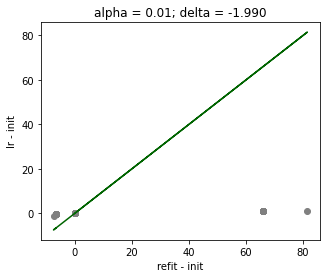

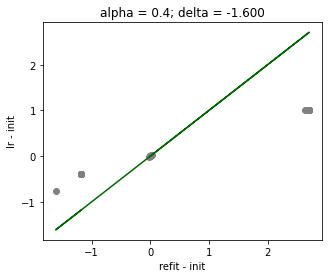

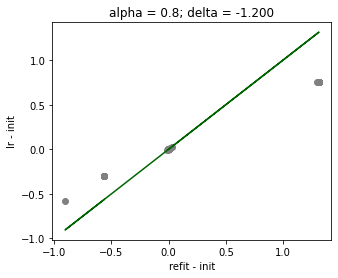

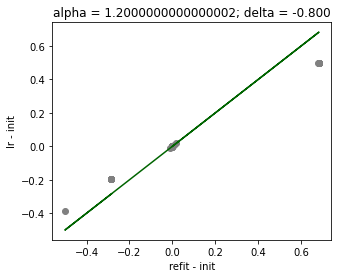

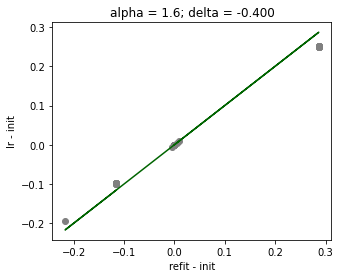

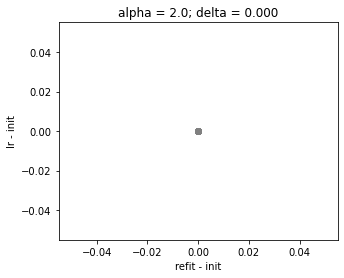

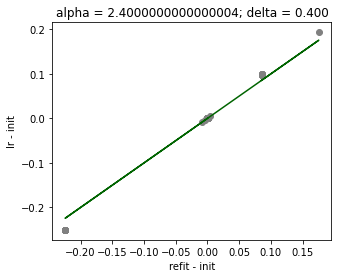

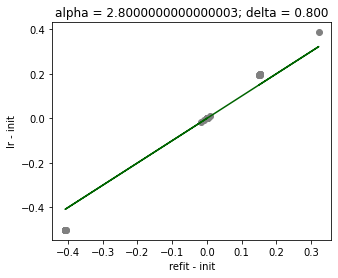

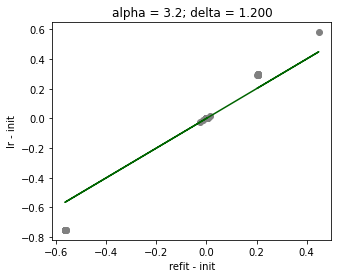

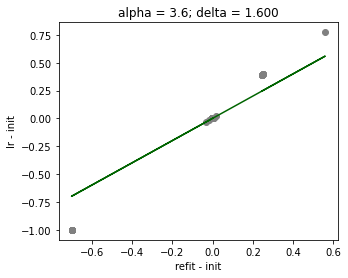

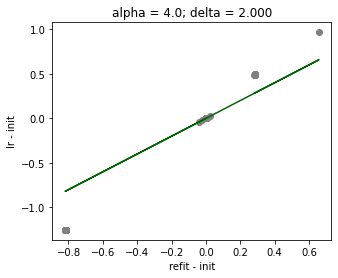

In [39]:
for i in range(len(alpha_list)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                    lr_list[i],
                    vb_opt,
                    ax, alpha = 1.)
    
    alpha = alpha_list[i]
    hyper_param_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha,
                                                              free = use_free_alpha)
    delta = hyper_param_pert - hyper_param0
    plt.title('alpha = ' + str(alpha) + '; delta = {:.03f}'.format(delta[0]))
    

# Check results on number of clusters

### results on number of in-sample clusters

In [40]:
import numpy as onp

In [41]:
prng_key = jax.random.PRNGKey(223)

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = 0,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = iris_obs.shape[0],
                                                               threshold = 0,
                                                               prng_key = prng_key)

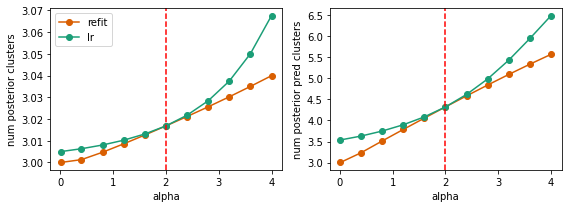

In [42]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
axarr[0].set_ylabel('num posterior clusters')
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend()

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])

axarr[1].set_ylabel('num posterior pred clusters')

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')

fig.tight_layout()

In [44]:
# save data on expected number of clusters
if save_data: 
    print('saving sensitivity results')
    np.savez(out_datadir + 'iris_alpha_sens', 
            alpha_list = alpha_list, 
            alpha0 = alpha0, 
            # in-sample quantities
            n_clusters_refit = result_loading_utils.get_post_stat_vec(get_n_clusters_insample, refit_list), 
            n_clusters_lr = result_loading_utils.get_post_stat_vec(get_n_clusters_insample, lr_list),
             # predictive quantities
            n_clusters_pred_refit = result_loading_utils.get_post_stat_vec(get_n_clusters_pred, refit_list), 
            n_clusters_pred_lr = result_loading_utils.get_post_stat_vec(get_n_clusters_pred, lr_list))

saving sensitivity results


# save timing data

In [45]:
if save_data: 
    print('saving timing results')
    np.savez(out_datadir + 'iris_alpha_timing', 
             k_means_time = k_means_time, 
             init_fit_time = init_fit_time, 
             refit_time_vec = refit_time_vec, 
             lr_time_vec = lr_time_vec,
             hess_solve_time = hess_solve_time)

saving timing results


In [47]:
len(alpha_list)

11

In [50]:
result_loading_utils.get_post_stat_vec(get_n_clusters_insample, refit_list)

DeviceArray([3.        , 3.00130175, 3.00470166, 3.00856781, 3.01262961,
             3.01682565, 3.02114848, 3.02560902, 3.0302213 , 3.03499489,
             3.0399386 ], dtype=float64)